In [1]:
%matplotlib inline

import json
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding, Isomap
from MulticoreTSNE import MulticoreTSNE
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA, SparsePCA
import umap
from scipy.sparse import vstack
import pandas as pd
from gb_writer import GlyphboardWriter
# from sklearn.model_selection import GridSearchCV
from typing import Any
import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import spacy
from spacy.lang.de.stop_words import STOP_WORDS


nlp = spacy.load('de')

C:\Users\ducanh.trinh\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


In [214]:
# Classifiers
SGD = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3,
                    random_state=42, max_iter=5, tol=None)
MNB = MultinomialNB()
LR = LogisticRegression()
SVC = LinearSVC()
KNC = KNeighborsClassifier()
NC = NearestCentroid()
RFC = RandomForestClassifier()

vec = TfidfVectorizer(strip_accents='ascii', max_df=0.5, sublinear_tf=True)
SPLICE_POINT = 800
UNLABELED_VALUE = -1

In [241]:
def init():
    print('Updating JSON...')
    updateDatasetJson()
    # print('Cleaning Texts...')
    # cleanupTexts()
    print('Done')

def mockInit():
    texts = []
    labels = []
    ids = []
    peer_labels = []
    with open("test_data.json", "r") as read_file:
        LC_data = json.load(read_file)

    for doc in LC_data:
        ids.append(doc['id'])
        texts.append(doc["values"]["7"])
        peer_labels.append(doc["features"]["1"]["4"])
        # simulate all as labeled (for test_data)
        if (doc["features"]["1"]["4"] > 0.5):
            labels.append(1)
        else:
            labels.append(0)

    df = pd.DataFrame({
        'id': ids,
        'text': texts,
        'label': labels,
        'peer_label': peer_labels,
        'score': [0] * len(LC_data),
        'isLabeled': [0]  * len(LC_data)
    })
   
    test_data = df[SPLICE_POINT+1:]
    saveData(test_data, 'test_data')
    # test_data.to_csv('test_data.csv', sep=";", encoding="utf8", index=False)
    data_with_scores = getSelectionScores(rest_data=df)
    saveData(data_with_scores)
    resetTrainData()
    
    # data_with_scores.to_csv('data.csv', sep=";", encoding="utf8", index=False)
    # resetTrainData()

def loadData(name = 'data'):
    return pd.read_csv('{}.csv'.format(name), sep=";", encoding="utf-8")

def saveData(data, name = 'data'):
    with open('{}.csv'.format(name), mode='w', newline='\n', encoding='utf-8') as f:
        data.to_csv(f, sep=";", line_terminator='\n', encoding='utf-8', index=False)
    # data.to_csv('mlbackend/{}.csv'.format(name), sep=";", encoding="utf-8", index=False)

def handleNewAnswer(answer):
    newAnswer = {
        'text': answer['text'],
        'docId': answer['documentId'],
        'label': int(answer['answer']),
        'question': answer['questionId']
    }
    train_data = getTrainData()

    test_data = getTestData()
    
    data = updateDataWithLabel(loadData(), newAnswer['docId'], newAnswer['label'])
    if len(train_data) > 3:
        # tfidf = vec.fit_transform(data.text)        
        # positions = applyDR(tfidf, withPreviousPos=False, labels=data.label)
        # writer = GlyphboardWriter('test_name')
        # position_response = writer.write_position(positions=positions, algorithm='umap')
        train_result = train(train_data, test_data, SGD)
        return {
            # 'positions': position_response,
            'train_result': train_result
        }
    else:
        return ''

def handleCompleteUpdate():
    data = loadData()
    # updateDatasetJson()
    tfidf = vec.fit_transform(data.text)
    positions = applyDR(tfidf, withPreviousPos=True, labels=data.label)
    writer = GlyphboardWriter('test_name')
    position_response = writer.write_position(positions=positions, algorithm='umap')
    return position_response

def updateDatasetJson():
    with open("test_data.json", "r") as read_file:
        LC_data = json.load(read_file)
        
    data = loadData()

    for doc in LC_data:
        doc['features']['1']['31'] = int(data.loc[data['id'] == doc['id']].isLabeled.values[0])
        doc['values']['31'] = int(data.loc[data['id'] == doc['id']].isLabeled.values[0])
        doc['features']['1']['32'] = float(data.loc[data['id'] == doc['id']].score.values[0])
        doc['values']['32'] = float(data.loc[data['id'] == doc['id']].score.values[0])
        doc['features']['1']['33'] = int(data.loc[data['id'] == doc['id']].label.values[0])
        doc['values']['33'] = int(data.loc[data['id'] == doc['id']].label.values[0])

    with open("../backend/data/mainTfIdf/mainTfIdf.05112018.feature.json", "w") as f:
            json.dump(LC_data, f)
    
    return 'Done'

# def updateSingleData(id: number, label, isLabeled):
#     data = loadData()
#     json = 

def updateDataWithLabel(data, docId, label):
    print('before', data.loc[data['id'] == docId])
    data.loc[data['id'] == docId, 'label'] = int(label)
    data.loc[data['id'] == docId, 'isLabeled'] = 1
    print('after', data.loc[data['id'] == docId])
    saveData(data)

    return data


def createMetrics(algo, train_data):
    test_data = getTestData()
    train_data.label = train_data.label.astype(int)
    met = []
    # Create stepwise metrics algo, simulating a history
    for number in range(30, len(train_data)):
        train_data_iteration = train_data.head(number)
        met.append(train(train_data_iteration, test_data, algo=algo))
    return pd.DataFrame(met)


def train(train_data, test_data, algo: Any) -> dict:
    text_clf = Pipeline([
        # ('vect', CountVectorizer()),
        ('tfidf', vec),
        ('clf', algo),
    ])
    text_clf.fit(train_data.text, train_data.label)
    predicted = text_clf.predict(test_data.text)
    addHistory(metrics.f1_score(test_data.label, predicted))
    result = {
        'precision': metrics.precision_score(test_data.label, predicted),
        'recall': metrics.recall_score(test_data.label, predicted),
        'f1': metrics.f1_score(test_data.label, predicted),
        'f1_history': getHistory()
    }
    return result

def getTrainData():
    data = loadData()
    return data.loc[data['isLabeled'] == 1]

def getTestData():
    return pd.read_csv('test_data.csv', delimiter=';', encoding="utf8")

def resetTrainData():
    data = loadData()
    data.loc[:, 'label'] = UNLABELED_VALUE
    data.loc[:, 'isLabeled'] = 0
    saveData(data)

def cleanupTexts():
    data = loadData()
    for idx, text in enumerate(data.text):
        data.loc[idx, 'text'] = preprocessText(text)
        
    saveData(data)

def mockTraining(amount):
    data = loadData()
    for i in range(amount):
        data.loc[i, 'isLabeled'] = 1
        if data.loc[i].peer_label > 0.5:
            data.loc[i, 'label'] = 1
        else:
            data.loc[i, 'label'] = 0        
    saveData(data)

def simulateTraining(iterations):
    test_data = getTestData()
    mockTraining(iterations)
    train_data = getTrainData()
    train(train_data, test_data, SGD)

def getHistory():
    history = []
    with open(
            "metrics.csv", "r", encoding="utf8") as file:
        reader = csv.reader(file, delimiter=';')
        for line in reader:
            history.append(line[0])
        file.close()
    return history


def addHistory(metrics):
    with open(
            "metrics.csv", "a",  newline="", encoding="utf8") as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow([str(metrics)])
        file.close()

def getCurrentScore() -> int:
    return getHistory().pop()

def applyDR(tfidf, labels = [], withPreviousPos = True, factor = 1):    
    # pre_computed = TruncatedSVD(n_components=100, random_state=1).fit_transform(tfidf.toarray())
    # LABEL_IMPACT = 0
    if withPreviousPos:        
        previousPositions = loadData('previousPositions').values
    else:
        previousPositions = 'spectral'
    labels_arr = np.asarray(labels)
    labels_arr = labels_arr.reshape(len(labels_arr), 1)
    # with_labels = np.hstack((tfidf.toarray(), labels_arr))
    computed_coords = umap.UMAP(init=previousPositions,min_dist=0.8, random_state=1, learning_rate=0.5).fit(tfidf.toarray(), y=labels_arr)
    computed_coords = computed_coords.embedding_
    saveData(pd.DataFrame(computed_coords), 'previousPositions')
    computed_coords *= factor    
    # computed_coords = MulticoreTSNE(n_jobs=4, random_state=1).fit_transform(with_labels)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = computed_coords[:, 0]
    df['y'] = computed_coords[:, 1]
    
    return df

# def resetPositions():


def preprocessText(text: str) -> str:
    # print('Original: ', text)
    doc = nlp(text)
    # Remove Stop Words and get Lemmas
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])
    # for word in doc:
    #     if word.is_stop == True:
    #         print('Stop %s', word)
    # print(word.lemma_)

#             # Get NER
#     for ent in doc.ents:
#         print(ent.text, ent.start_char, ent.end_char, ent.label_)

def getSelectionScores(rest_data, train_data, clf = MNB): 
    text_clf = Pipeline([
        # ('vect', CountVectorizer()),
        ('tfidf', vec),
        ('clf', clf),
    ])
    text_clf.fit(train_data.text, train_data.label)
    prs = text_clf.predict_proba(rest_data.text) 
    result_pos = [1-2*abs(x[1]-0.5)  for x in prs]
    rest_data['score'] = result_pos
    return rest_data

In [163]:
mockInit()

In [164]:
mockTraining(1000)

In [8]:
getTrainData()

,id,isLabeled,label,peer_label,score,text
294,295,1,1,1.00000,0.995374,GARDENS END Sommerspecial - Die Rockband Garde...
398,399,1,1,0.00000,0.497636,Sand in der Ritze #2 Nach einer gemütlichen un...
540,541,1,0,0.00000,0.684377,The next Gamestorm Cocktail! Der Gamestorm bek...
666,667,1,1,1.00000,0.991680,Klassisches Konzert Costabell Romantischer Kla...
802,803,1,0,0.68750,0.927309,"Sommerakademie 2014 ""Mystik und Alltag im int..."
947,948,1,1,0.96875,0.956348,Jazz im Weingut Pix Jazz im Weingut Pix\r\r\r\...


In [42]:
# cleanupTexts()
data = loadData()
tfidf = vec.fit_transform(data.text)
positions = applyDR(tfidf, labels=np.empty(1118), withPreviousPos=False)


In [43]:
writer = GlyphboardWriter('test_name')
position_response = writer.write_position(positions=positions, algorithm='umap')

FileNotFoundError: [Errno 2] No such file or directory: 'backend/data/mainTfIdf/mainTfIdf.05112018.position.umap.json'

In [176]:
# mock everything for demo
saveData(getSelectionScores())
resetTrainData()
mockTraining(800)
updateDatasetJson()

'Done'

In [219]:
# Check important features of classification
# cleanupTexts()
train_data = getTrainData()
tfidf = vec.fit_transform(train_data.text)
clf = SGD
clf.fit(tfidf, train_data.label)
feature_names = vec.get_feature_names()
coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
top = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ('\t%.4f\t%-15s\t\t%.4f\t%-15s' % (coef_1, fn_1, coef_2, fn_2))


	-1.3293	bitte          		2.6206	dj             
	-1.0654	vom            		2.3784	musik          
	-1.0317	rumanischer    		1.8630	konzert        
	-0.9783	events         		1.6224	live           
	-0.9345	tag            		1.5546	music          
	-0.8810	at             		1.4208	songs          
	-0.8384	zumba          		1.4050	rock           
	-0.7965	anmeldung      		1.3063	band           
	-0.7716	uber           		1.2774	party          
	-0.7651	viele          		1.2197	beginn         
	-0.7581	da             		1.1125	jazz           
	-0.7098	kuchen         		1.0994	saint          
	-0.7046	bis            		1.0393	special        
	-0.6926	30             		1.0368	gesang         
	-0.6923	isler          		1.0325	nr             
	-0.6923	organize       		1.0196	musiziert      
	-0.6847	kinder         		1.0111	das            
	-0.6750	tel            		0.9941	dem            
	-0.6745	discoflieger   		0.9738	los            
	-0.6622	17             		0.9657	lu             


In [215]:

resetTrainData()
mockTraining(300)
train_data = getTrainData()
SGD_met = createMetrics(SGD, train_data)
# MNB_met = createMetrics(MNB)
# KNC_met = createMetrics(KNC)
# NC_met = createMetrics(NC)
# RFC_met = createMetrics(RFC)
# getTrainData()


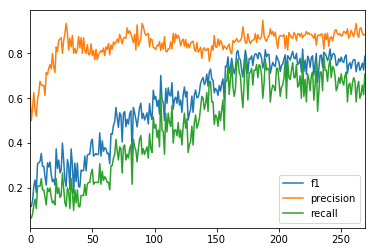

In [216]:
SGD_met.plot()

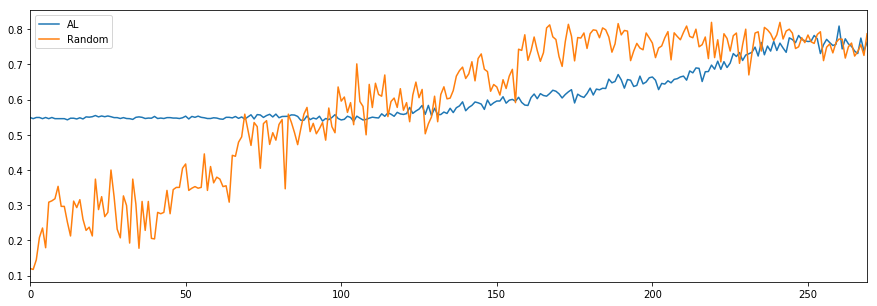

In [243]:
pd.DataFrame({'Random': SGD_met.f1, 'AL': SGD_AL.f1}).plot(figsize=(15, 5))

In [ ]:
KNC_met.plot()

In [ ]:
NC_met.plot()

In [ ]:
RFC_met.plot()